# Homework 4: SARS-CoV-2 variants - How fast does the virus evolve?

Viruses are not immune to mutations and evolution.
During the pandemic, the SARS-CoV-2 virus mutated, evolved, and changed its characteristics, leaving us with various new strains and variants.


The evolution of new strains is tied to their rate of mutation.
Therefore, we must know how fast they mutate to understand their evolution.
Their mutation rate is meaningless without some references; thus, we will compare it to the rate of mutations of other viruses.
Apart from the rate, the location of mutations is vital for evolving new characteristics while preserving their viability.
Some specific mutations give rise to a new variant, and we will be interested in where those mutations happen in different variants.
Lastly, we will focus on Australia and its variant landscape throughout the pandemic.

In [ ]:
import numpy as np          
import pandas as pd         # for saving classification in P4
from Bio import SeqIO       # for reading fasta files

## Problem 1: Rate of mutation

How fast is the SARS-CoV-2 virus evolving? Can we empirically determine the speed of mutation? We can! Most biologists are very meticulous with their experiments and carefully document when samples are collected. We can then take a bunch of viral genomes, select a reference genome (usually the first known occurrence of the virus), and calculate the number of mutations from the reference to the remaining viral genomes. We can then use this information in conjunction with the sample collection dates to estimate how fast the viruses are evolving.

**Task:**
Implement the `jukes_cantor` function in `helper_functions.py` to calculate the genetic distance using Hamming distance and Jukes-Cantor correction. Note that Jukes-Cantor correction ignores insertions and deletions, so when calculating the length of the sequence, you should ignore positions with indels. As a hint, JC corrected and non-corrected genetic distance (ignoring indels) for SARS-CoV-2 sequences should be fairly similar and have the same unit.

Example:
```
AGGT-GA
AGC-AGA
```
This alignment has non-corrected genetic distance (ignoring indels) equal to 1, while JC corrected genetic distance is 1.163.

You have 211 SARS-CoV-2 genomes aligned to the reference (_NC_045512.2_).
You can find their collection date and country in their fasta description (`data/p1-sars-cov-2-variants.fasta`).

Find the first collected instance of SARS-CoV-2, i.e., the virus, with the earliest collection date. We'll use our NCBI reference (_NC_045512.2_) as a reference virus. Make sure to download the reference from the NCBI.
You can use a pandas function `pd.to_datetime()` to convert collection dates into a Timestamp. Timestamps without the explicit day of the month will convert into the first day of the month.

Calculate the JC corrected genetic distance from the reference sequence to all other and plot its dependence on the time elapsed from this starting point.

Create a scatterplot of viruses, where you put genetic distance on the y-axis and time in days (the number of days since the starting point) on your x-axis. The earliest sequence should be located at the origin (0, 0).
Estimate the mutation rate using linear regression and overlay your plot with the regression line.

Mutation rate is the number of mutations divided by the elapsed time. We consider mutations per genome and also per nucleotide. If the above example are two sequences one day apart, then the mutation rate **per genome per day** is 1.163 and mutation rate **per nucledtide per day** is 0.2326. Think about the meaning of these numbers and why we need both of them.

Report the mutation rate per genome per day and save it into the `sars_cov_2_per_genome_per_day` variable. 
Report the mutation rate per nucleotide per day and save it into the `sars_cov_2_per_nt_per_day` variable. 
Save the resulting figure into `problem1.svg`.


Then answer the following question about Jukes-Cantor corrrection:
- Describe why we need the JC correction and why we can’t use raw distances.

Save your answers in the variable `need_for_JC_correction`, respectively.

Hint: check out `np.polyfit` to fit the linear regression curve. Include your reference in the linear fit and account for the intersection when plotting your fit.

**[10 points]** 


In [512]:
# TODO
import numpy as np
reference_sequence="AGGT-GA"
distant_sequence=  "AGC-AGA"

def temp_calc(reference_sequence,distant_sequence): 
   sim = 0 
   indel = 0 
   n = len(reference_sequence)  
   for i in range(n): 
      if( list(reference_sequence)[i] == list(distant_sequence)[i]): 
         sim += 1 
      if( reference_sequence[i] == "-"):
         indel +=1
      if( distant_sequence[i] == "-"):
         indel +=1     
   n = n - indel  
   d = n - sim 
   p = d/n 
   d_corrected = -(3/4)*np.log(1 - (p*(4/3)))
   return(d_corrected,n,d,p)
   
def conv(x):
   if( x == 'A'): 
      y=1 
   elif( x == 'G'): 
      y=2
   elif( x == 'C'): 
      y=3
   elif( x == 'T'): 
      y=4
   else:
      y=5
   return y   
      
def conv_back(x):
   if( x == '1'): 
      y='A' 
   elif( x == '2'): 
      y='G'
   elif( x == '3'): 
      y='C'
   elif( x == '4'): 
      y='T'
   else:
      y='-'
   return y   
      

def jc_calc(reference_sequence,distant_sequence): 
   ref = (''.join(map(str, map(conv, reference_sequence))))   
   dis = (''.join(map(str, map(conv, distant_sequence))))   
   data={"reference":list(ref) ,"distant":list(dis)}
   data_df = pd.DataFrame(data )
   data_df['reference'] = data_df['reference'].astype(int) 
   data_df['distant'] = data_df['distant'].astype(int)   
   data_df.query("reference < 5", inplace=True)
   data_df.query("distant < 5", inplace=True)
   hamm = sum(abs(data_df['reference']  - data_df['distant'] ))
   n=len(data_df['reference'])
   p = hamm/n 
   d_corrected = -(3/4)*np.log(1 - (p*(4/3)))
   return(d_corrected,n,hamm,p)

#print(temp_calc(reference_sequence,distant_sequence))
#print(jc_calc(reference_sequence,distant_sequence))

In [35]:
sars_cov_2_per_genome_per_day = 0.0 
sars_cov_2_per_nt_per_day = 0.0

In [50]:
from Bio import Entrez
Entrez.email = "s.ballouz@unsw.edu.au"

query_id = "NC_045512.2"
handle = Entrez.efetch(db="nuccore", id=query_id, retmode="xml")
info_record = Entrez.read(handle)
handle.close()
query_seq = info_record[0]["GBSeq_sequence"]

In [532]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
import json

In [ ]:
seqs_dict={}
input_handle=open("data/p1-sars-cov-2-variants.fasta" , "r")
for record in SeqIO.parse(input_handle, 'fasta'): 
   seqs_dict[record.id] = record.seq
   
#key1='EPI_ISL_2789189|Slovenia|2021-05-29'
#key='EPI_ISL_2789042|Slovenia|2021-05-26'
key='MT517433.1|China|2020-03-28'
#key = next(iter(seqs_dict))

dist_dict={}
for i in seqs_dict.keys():   
   dist_dict[i]= jc_calc(seqs_dict[key], seqs_dict[i])

labels_dict={}
all_keys = dist_dict.keys()
for key in all_keys: 
    temp= re.split("\|", key)
    labels_dict[key]= temp 

data_df = pd.DataFrame(labels_dict )
data_df = data_df.transpose()
data_df = data_df.rename( columns={0:'ID',1:'Location', 2: 'Date'} )
data_df['Date']=pd.to_datetime(data_df['Date'],format='mixed')
labels_df = data_df 

data_df = pd.DataFrame(dist_dict )
data_df = data_df.transpose()
data_df = data_df.rename( columns={0:'d',1:'n', 2: 'd_corrected', 3:'Fraction' } )

sars_data_df = labels_df.join(data_df)
sars_data_df['JC'] = all_data_df['n']*all_data_df['d_corrected']


In [ ]:
x = np.array(sars_data_df['Date'])[1:]
y = np.array(sars_data_df['d_corrected'])[1:]
x1=mdates.date2num(x)
data={'Date':x1,'d_corrected':y}
sars_temp_df=pd.DataFrame( data )

<Axes: xlabel='Date', ylabel='d_corrected'>

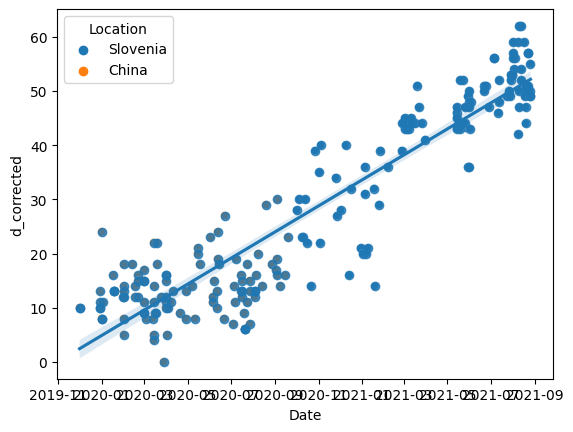

In [302]:
#sns.FacetGrid(data=sars_data_df, aspect=3)
sns.scatterplot(data=sars_data_df, x='Date', y='d_corrected', hue='Location')
sns.regplot(data=sars_temp_df, x='Date', y='d_corrected')


In [ ]:
need_for_JC_correction = """
Describe why we need the JC correction and why we can’t use raw distances.
"""

## Problem 2a: Mutation rate in other viruses

We've estimated the regression slope to SARS-CoV-2. Now what? Does the plot indicate a fast mutation rate? Or a slow mutation rate? Or an average mutation rate? We really can only tell with a frame of reference. In this exercise, we will look at two more viruses from recent outbreaks, the Zaire ebolavirus, and Zika virus, and determine their mutation rate. These will help us get a sufficient reference for the speed at which viruses mutate.

**Task:**
Find the aligned sequences for Ebola and Zika virus in the `data/p2-ebola-viruses.fasta` and `data/p2-zika-viruses.fasta`.
Use the first viral genomes in files as the reference, as these are the earliest known and sequenced viruses.
Follow the same procedure as in Problem 1 to estimate the slope of the regression line. 

Since these viruses have been around longer than SARS-CoV-2, they are more diverse, and the distances between them may be longer.
We observe this if the reference sequence is at the origin, but the others start much higher, i.e., the line fitting the remaining viruses doesn't go through the origin but is shifted higher up.
In this case, ignore the reference sequence when fitting the regression lines.

Report the genome and nucleotide rate of mutation of both viruses and save them into their corresponding variables (`ebola_per_genome_per_day`, `ebola_per_nt_per_day` and `zika_per_genome_per_day`, `zika_per_nt_per_day`).

Then answer the following questions:
- Why did we ignore the reference when fitting the regression line? Keep in mind that in our biological interpretation, this is not an outlier in the machine learning sense. _Hint: think about what assumption are we making when using the reference in the regression fit_.
- When comparing mutation rates between different viruses, should we compare them on a per genome or a per nucleotide basis? Why?

Save your answers in the variables `reference_in_regression` and `comparing_mutation_rates`, respectively.

**[7 points]**


**Why did we choose these two reference viruses?** SARS-CoV-2 is in a unique position where it is a worldwide phenomenon and warranted a global response in the past. As such, SARS-CoV-2 is most likely the most well-documented and tracked virus of all time. Even five years ago, sequencing on this scale would have been impossible. This creates a problem when we want to compare the mutation rate with other viruses. We need reference viruses that have gone through a similar lifecycle to SARS-CoV-2 and need to be recent enough such that sufficient sequencing data is available to estimate the slopes correctly. Unfortunately for us (but thankfully for humanity), only a handful of viruses fit this description (https://en.wikipedia.org/wiki/List_of_epidemics). Additionally, some developing countries still need the technological or economic capability to carry out this kind of sequencing on a large scale, making reliable data challenging to come by. We have chosen the Ebola virus and Zika virus, as their sequencing data is more or less reliable and plentiful enough.

In [ ]:
# TODO
seqs_dict={}
input_handle=open("data/p2-ebola-viruses.fasta" , "r")
for record in SeqIO.parse(input_handle, 'fasta'): 
   seqs_dict[record.description] = record.seq

key = next(iter(seqs_dict))

dist_dict={}
for i in seqs_dict.keys():   
   dist_dict[i]= jc_calc(seqs_dict[key], seqs_dict[i])

labels_dict={}
all_keys = dist_dict.keys()
for key in all_keys: 
    temp= re.split("\|", key)
    labels_dict[key]= temp 

data_df = pd.DataFrame(labels_dict )
data_df = data_df.transpose()
data_df = data_df.rename( columns={0:'ID',1:'Location', 2: 'Date'} )

data_df['Date']=pd.to_datetime(data_df['Date'],format='mixed')
labels_df = data_df 

data_df = pd.DataFrame(dist_dict )
data_df = data_df.transpose()
data_df = data_df.rename( columns={0:'d',1:'n', 2: 'd_corrected', 3:'Fraction' } )

ebola_data_df = labels_df.join(data_df)
ebola_data_df['JC'] = all_data_df['n']*all_data_df['d_corrected']

x = np.array(ebola_data_df['Date'])[1:]
y = np.array(ebola_data_df['d_corrected'])[1:]
x1=mdates.date2num(x)
data={'Date':x1,'d_corrected':y}
ebola_temp_df=pd.DataFrame( data )

In [ ]:
seqs_dict={}
input_handle=open("data/p2-zika-viruses.fasta" , "r")
for record in SeqIO.parse(input_handle, 'fasta'): 
   seqs_dict[record.description] = record.seq

#seqs_dict.keys()    
#key1='EPI_ISL_2789189|Slovenia|2021-05-29'
#key='EPI_ISL_2789042|Slovenia|2021-05-26'
#key='MT517433.1|China|2020-03-28'
key = next(iter(seqs_dict))

dist_dict={}
for i in seqs_dict.keys():   
   dist_dict[i]= jc_calc(seqs_dict[key], seqs_dict[i])

labels_dict={}
all_keys = dist_dict.keys()
for key in all_keys: 
    temp= re.split("\|", key)
    labels_dict[key]= temp 

data_df = pd.DataFrame(labels_dict )
data_df = data_df.transpose()
data_df = data_df.rename( columns={0:'ID',1:'Location', 2: 'Date'} )

data_df['Date']=pd.to_datetime(data_df['Date'],format='mixed')
labels_df = data_df 

data_df = pd.DataFrame(dist_dict )
data_df = data_df.transpose()
data_df = data_df.rename( columns={0:'d',1:'n', 2: 'd_corrected', 3:'Fraction' } )

zika_data_df = labels_df.join(data_df)
zika_data_df['JC'] = all_data_df['n']*all_data_df['d_corrected']

x = np.array(zika_data_df['Date'])[1:]
y = np.array(zika_data_df['d_corrected'])[1:]
x1=mdates.date2num(x)
data={'Date':x1,'d_corrected':y}
zika_temp_df=pd.DataFrame( data )

<Axes: xlabel='Date', ylabel='d_corrected'>

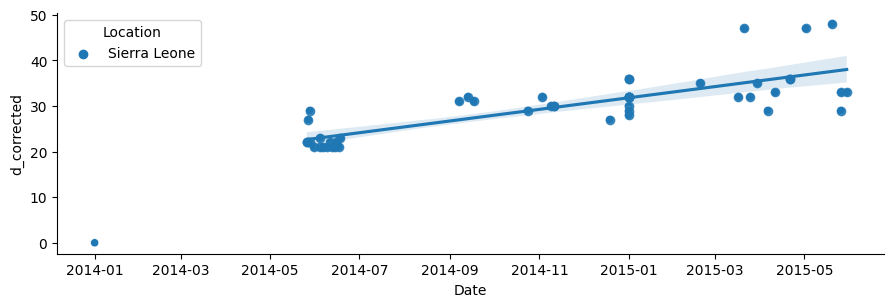

In [303]:
sns.FacetGrid(data=ebola_data_df, aspect=3)
sns.scatterplot(data=ebola_data_df, x='Date', y='d_corrected', hue='Location')
sns.regplot(data=ebola_temp_df, x='Date', y='d_corrected')

<Axes: xlabel='Date', ylabel='d_corrected'>

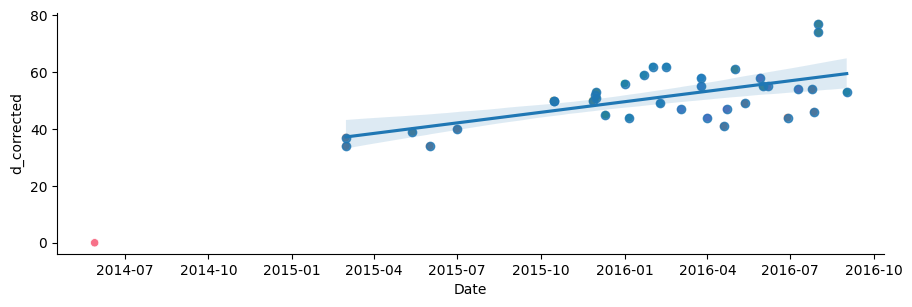

In [304]:
sns.FacetGrid(data=zika_data_df, aspect=3)
sns.scatterplot(data=zika_data_df, x='Date', y='d_corrected', hue='Location', legend=False)
sns.regplot(data=zika_temp_df, x='Date', y='d_corrected')

In [ ]:
x = np.array(sars_data_df['Date'])[1:]
y = np.array(sars_data_df['d_corrected'])[1:]
x=x.reshape(-1,1)
model = LinearRegression().fit(x, y) 
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

 
x = np.array(sars_temp_df['Date'])
y = np.array(sars_temp_df['d_corrected'])
x=x.reshape(-1,1)
model = LinearRegression().fit(x, y) 
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")


intercept: -1426.9941781655737
slope: [9.07488791e-16]
coefficient of determination: 0.8522723875033238
intercept: -1426.9941781655739
slope: [0.07840703]


In [ ]:
x = np.array(zika_data_df['Date'])[1:]
y = np.array(zika_data_df['d_corrected'])[1:]
x=x.reshape(-1,1)
model = LinearRegression().fit(x, y) 
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

x = np.array(zika_temp_df['Date'])
y = np.array(zika_temp_df['d_corrected'])
x=x.reshape(-1,1)
model = LinearRegression().fit(x, y) 
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")


intercept: -630.8518452989747
slope: [4.6877212e-16]
coefficient of determination: 0.38630709159873455
intercept: -630.8518452989741
slope: [0.04050191]


In [ ]:
x = np.array(ebola_data_df['Date'])[1:]
y = np.array(ebola_data_df['d_corrected'])[1:]
x=x.reshape(-1,1)
model = LinearRegression().fit(x, y) 
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")


x = np.array(ebola_temp_df['Date'])
y = np.array(ebola_temp_df['d_corrected'])
x=x.reshape(-1,1)
model = LinearRegression().fit(x, y) 
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")


intercept: -652.3899219530539
slope: [4.81796737e-16]
coefficient of determination: 0.6437890704890064
intercept: -652.3899219530541
slope: [0.04162724]


In [ ]:
ebola_per_genome_per_day = 0.0 
ebola_per_nt_per_day = 0.0

zika_per_genome_per_day = 0.0 
zika_per_nt_per_day = 0.0

In [ ]:
reference_in_regression = """
Why did we ignore the reference when fitting the regression line? Keep in mind that in our biological interpretation, this is not an outlier in the machine learning sense.
"""

In [ ]:
comparing_mutation_rates = """
When comparing mutation rates between different viruses, should we compare them on a per genome or a per nucleotide basis? Why?
"""

## Problem 2b: Reinterpreting mutation rates

Majority of RNA viral genomes are single-stranded RNA, where only one strand of the viruses encode for the genes. We divide these viruses into positive-sense and negative-sense viruses, based on where they code for genes.
Positive-sense RNA directly codes for genes and acts like mRNA, meaning it can be directly used by the host's ribosomes to make proteins.
Negative-sense RNA is a reverse complement of the positive-sense RNA and does not code for genes directly. It must first be converted into positive-sense RNA by the virus's own enzymes before it can be used to make proteins.
Positive-sense RNA viruses mutate faster because their replication process is simpler and mostly lacks error correction. Negative-sense RNA viruses, on the other hand, mutate more slowly since they have an extra step in replication and require more functional genes to support replication.

Answer the following questions about mutation rates based on the sense-type of the viruses:
- What type of sense (positive or negative) are Zika, Ebola and SARS-CoV-2? Search the web or NCBI.
- How does the mutation rate of SARS-CoV-2, based on its sense-type, compare to another virus with the same sense-type in our three examples? Specifically, is SARS-CoV-2 mutating faster or slower than that virus?
- Is there a molecular mechanism of SARS-CoV-2 that explains the answer above?

Save your answers in the variables `sense_types_of_viruses`, `sars_cov_2_faster_slower` and `mutation_molecular_mechanism`, respectively.

**[3 points]** 

In [ ]:
sense_types_of_viruses = """
What type of sense (positive or negative) are Zika, Ebola and SARS-CoV-2? Search the web or NCBI.
"""

In [ ]:
sars_cov_2_faster_slower = """
How does the mutation rate of SARS-CoV-2, based on its sense-type, compare to another virus with the same sense-type in our three examples? Specifically, is SARS-CoV-2 mutating faster or slower than that virus?
"""

In [ ]:
mutation_molecular_mechanism = """
Is there a molecular mechanism of SARS-CoV-2 that explains the answer above?
"""

## Problem 3: Variant-specific mutations

As the virus mutates, it inevitably evolves and proliferates around the world. Every so often, some mutations may prove especially beneficial to the spread of the virus, and this version of the virus spreads faster than other versions. When a version of a virus becomes especially prevalent inside a population, we call this a virus *variant*. Variants are nothing more than a naming scheme for viruses that have specific mutations. For instance, in Slovenia during 2022, we were dealing with the Omicron variant. Think of this as observing natural selection in real time. Some viruses have mutations that enable them to spread more easily throughout our population, which inevitably leads to the demise of other virus variants, which are not as good at proliferation. The result is survival of the fittest at the viral level, where, unfortunately, the fittest viruses seem to cause the most damage to us humans.

How do we identify variants? A variant is determined by several so-called *defining mutations*. Mutations can either be synonymous or nonsynonymous. Synonymous mutations are changes in nucleotide bases that result in the same encoded amino acid and are thus less important. Nonsynonymous mutations are nucleotide mutations that alter the amino acid sequence of a protein.

To determine mutations, we first have to select a reference genome, which we will say has no mutations. In most cases, this is the first known occurrence of the virus, but in our case, the reference NCBI genome from Wuhan in 2019 (_NC_045512.2_).
Then, we align each viral genome of interest to this reference genome. All the differences between the reference genome and the genome of interest are said to be mutations.

To get a sense of the distribution of mutations across the genome in a variant, we will observe the most common mutations in **Alpha** (20I (Alpha, V1)) and **Delta** (21A (Delta)) variants. We will then try to answer whether the Delta variant emerged from the Alpha variant or evolved independently from a different strain of the virus.

**Task:**
Use pre-aligned sequences from the file `data/p1-sars-cov-2-variants.fasta`. To facilitate indexing, the reference sequence in the alignment has no indels. Extract the Alpha and Delta variants according to the indices in lists `alpha_variants` and `delta_variants`, respectively.

Calculate the nucleotide mismatches between each sequence and the reference sequence for the variant. Then, compute the average mismatch ratio for each nucleotide position to generate an array of mutation frequencies ranging from 0 to 1. A value of 0 means no mutations occurred at that position in any sequence, while a value of 1 indicates that all sequences have a mutation at that position relative to the reference. Ensure that mutations are calculated separately for each variant.

Plot the mutation occurrences across the whole genome for the Alpha and Delta variants separately on one figure (two subplots, one on top of another). Represent the mutation occurance as a line plot (_ax.plot_ or _plt.plot_) were x-axis is sequence index and y-axis is the average mutation occurance. Show only the part of the genome above the 20000 nucleotides and mark locations of the SARS-CoV-2 genes (with colors and labels). You can find gene locations in the `gene_locations` variable. Expect a few sites with occurrence one and the rest close to zero.

We say a mutation is vital if its occurrence is higher than 0.5. Find all vital mutations in the spike gene ("S") and compare results between variants. There are a few sites where both variants mutated, but only one where the same mutation occurred.

Store your plot in the `problem3.svg` and make it visually appealing.
Find indices of each site on the S gene where mutations occurred in both variants. Store integer sites into a `mutations_in_both_variants` variable where the site refers to the nucleotide in the reference genome.
Store the only same mutation into the `same_mutation` variable as a string denoting reference nucleotide, mutation site, and the variant nucleotide (e.g. "G123A", where G on position 123 in the reference mutates into an A.)


Then answer the following questions:
- Did the Delta variant evolve from the Alpha variant? Explain your reasoning based on the common mutations.

Save your answers in the variable `alpha_from_delta`, respectively.

**[10 points]**

In [314]:
gene_locations = {
    'S': (21462, 25284),
    'E': (26144, 26372),
    'M': (26422, 27091),
    'N': (28173, 29433)
}

alpha_variants  = ['EPI_ISL_2789189', 'EPI_ISL_2789042', 'EPI_ISL_1491060', 'EPI_ISL_1402029', 'EPI_ISL_6950370',
                    'EPI_ISL_1625411', 'EPI_ISL_1335421', 'EPI_ISL_2644151', 'EPI_ISL_2982899', 'EPI_ISL_2644156',
                    'EPI_ISL_2788965', 'EPI_ISL_2789059', 'EPI_ISL_2532608', 'EPI_ISL_2644516', 'EPI_ISL_2886579',
                    'EPI_ISL_3316487', 'EPI_ISL_2886574', 'EPI_ISL_2532626', 'EPI_ISL_2886496', 'EPI_ISL_2492172',
                    'EPI_ISL_2644108', 'EPI_ISL_1402024', 'EPI_ISL_2492224', 'EPI_ISL_2491984', 'EPI_ISL_2789018',
                    'EPI_ISL_2886831', 'EPI_ISL_1491132', 'EPI_ISL_2492034', 'EPI_ISL_1266392', 'EPI_ISL_2983056']

delta_variants = ['EPI_ISL_3039380', 'EPI_ISL_4271386', 'EPI_ISL_5213082', 'EPI_ISL_3316705','EPI_ISL_3316997',
                    'EPI_ISL_4251175', 'EPI_ISL_3471254', 'EPI_ISL_4271571', 'EPI_ISL_4270964', 'EPI_ISL_3317189',
                    'EPI_ISL_3829145', 'EPI_ISL_3317102', 'EPI_ISL_4923915', 'EPI_ISL_3829384', 'EPI_ISL_4923898',
                    'EPI_ISL_4270689', 'EPI_ISL_4270627', 'EPI_ISL_3828666', 'EPI_ISL_4253193', 'EPI_ISL_3828993',
                    'EPI_ISL_3039412', 'EPI_ISL_4923029', 'EPI_ISL_4251446', 'EPI_ISL_4271300', 'EPI_ISL_4271597',
                    'EPI_ISL_4271322', 'EPI_ISL_4922967', 'EPI_ISL_4251202', 'EPI_ISL_4251164', 'EPI_ISL_4270961',
                    'EPI_ISL_4270530', 'EPI_ISL_4270924', 'EPI_ISL_3829530', 'EPI_ISL_3828321', 'EPI_ISL_4271408',
                    'EPI_ISL_4271598', 'EPI_ISL_4924026', 'EPI_ISL_3316743']

In [ ]:
# TODO
alpha_dict = {} 
seqs_dict={}
input_handle=open("data/p1-sars-cov-2-variants.fasta" , "r")
for record in SeqIO.parse(input_handle, 'fasta'): 
   seqs_dict[record.id] = record.seq
 
 
 
variants=[]
for ID in sars_data_df['ID']:
   if( ID in alpha_variants):
      variants.append("alpha")
   elif( ID in delta_variants):
      variants.append("delta")
   else:   
      variants.append("unk")

#sars_data_df.insert(1, "Variant", variants)
sars_data_df

<Axes: xlabel='Date', ylabel='d_corrected'>

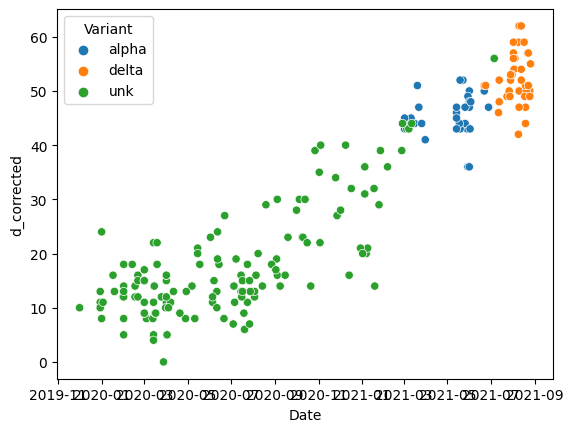

In [335]:
#sns.FacetGrid(data=sars_data_df, aspect=3)
sns.scatterplot(data=sars_data_df, x='Date', y='d_corrected', hue='Variant')
 

In [ ]:
mat_seq={}
for id in alpha_variants:
  key= (sars_data_df.index[sars_data_df['ID']==id])[0] 
  temp_seq=seqs_dict[key]
  ref = (''.join(map(str, map(conv, temp_seq))))   
  mat_seq[id] = list(ref)

key='MT517433.1|China|2020-03-28'
temp_seq=seqs_dict[key]
ref = list((''.join(map(str, map(conv, temp_seq)))))
ref=pd.DataFrame(ref) 

alpha_df = pd.DataFrame(data=mat_seq.values(), index=mat_seq.keys())
alpha_df=alpha_df.transpose()

mut_counts={}
for i in alpha_df.index:
    #alpha_df.loc[i].value_counts() 
    temp=list(alpha_df.loc[i])
    mut_counts[i]=temp.count(ref.iloc[i][0])


<Axes: >

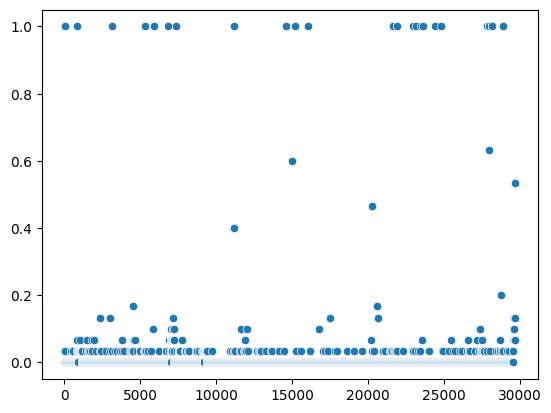

In [472]:
na = len(alpha_variants)
ya = np.array(list(mut_counts.values()))
ya = (na - ya) / na
xa = np.array(list(alpha_df.index))
 
sns.scatterplot(x=xa,y=ya)

In [461]:
mat_seq={}
for id in delta_variants:
  key= (sars_data_df.index[sars_data_df['ID']==id])[0] 
  temp_seq=seqs_dict[key]
  ref = (''.join(map(str, map(conv, temp_seq))))   
  mat_seq[id] = list(ref)

key='MT517433.1|China|2020-03-28'
temp_seq=seqs_dict[key]
ref = list((''.join(map(str, map(conv, temp_seq)))))
ref=pd.DataFrame(ref) 

delta_df = pd.DataFrame(data=mat_seq.values(), index=mat_seq.keys())
delta_df=delta_df.transpose()

mut_counts_del={}
for i in delta_df.index:
    #alpha_df.loc[i].value_counts() 
    temp=list(delta_df.loc[i])
    mut_counts_del[i]=temp.count(ref.iloc[i][0])

 

In [ ]:
nd = len(delta_variants)
yd = np.array(list(mut_counts_del.values()))
yd = (nd - yd) / nd
xd = np.array(list(delta_df.index))
sns.scatterplot(x=xd,y=yd)


In [518]:
#sns.scatterplot(x=xd,y=yd)
#sns.scatterplot(x=xa,y=ya, color="purple")

# sns.scatterplot(x=ya, y=yd)  
v_alpha= [i for i, x in enumerate(ya) if x == 1]
v_delta = [i for i, x in enumerate(yd) if x == 1]


key='MT517433.1|China|2020-03-28'
temp_seq=seqs_dict[key]

res = list(set(v_alpha) & set(v_delta))
print(res)
for pos in res:
    orig = temp_seq[pos]
    vara= conv_back(set(alpha_df.loc[pos]).pop()[0] )
    vard= conv_back(set(delta_df.loc[pos]).pop()[0] )
    if(vard == vara ): 
        #print(orig, pos, vard, vara)
        print(f"{orig}{pos}{vard}")

#temp_seq[res[1]]
#temp_seq[res[2]]
#temp_seq[res[3]]

print(len(v_alpha), len(v_delta) ) 


[7337, 59, 5925, 23503]
C7337T
A59G
T5925C
43 25


In [ ]:
mutations_in_both_variants = [1,2,3]
same_mutation = "G123A" # write your mutation in the form of f"{reference nt}{site number}{variant nt}"

In [ ]:
alpha_from_delta="""
Did the Delta variant evolve from the Alpha variant? Explain your reasoning based on the common mutations.
"""

## Problem 4: Identifying variants

As we've seen, mutations are not distributed uniformly across the genome. Important mutations at specific sites distinguish variants from each other. Nonsynonymous mutations are the ones reflected in the proteins they produce.

A standard convention is to denote mutations using a short string, e.g., *S:T 19 R*. The first part denotes the protein where the mutation has occurred. The second part is comprised of the actual mutation. For instance, *S:T 19 R* means that we are looking at a mutation on the S -- spike protein, where the original amino acid at location 19 was T -- threonine, which changed to R -- arginine. The "-" symbol indicates a deletion (e.g., *S:H 69 -*). For a complete reference of SARS-CoV-2 mutations, you can take a look at https://covariants.org and look through the different variants. We will not consider insertions in this homework, as it would only complicate our lives. Note that location of aminoacids in proteins start with 1 and not 0 like in python notation.

In this part of the assignment, we will take a handful of SARS-CoV-2 genomes from Australia and look at how the different variants spread throughout our country over time.
We will focus on the spike protein sequence as this will speed up computation.
Additionally, the spike protein sequence is the most interesting in terms of variants, as mutations on the spike protein directly affect its ability to spread throughout our population and potentially get around our vaccination efforts.

**Task**

You have XX  pre-aligned SARS-CoV-2 spike protein sequences collected from Australia at various time points (`data/p4-aus-spike-proteins.fasta`). Your job is to determine the variant of each spike protein sequence. We have also prepared a JSON file (*variants.json*) containing all the information on SARS-CoV-2 variants that you'll need. Use the variant names and nonsynonymous mutations defined in this file for your classification. We have removed some of the variants for the purposes of this assignment.

Your task is to look through each of the provided SARS-Cov-2 sequences and assign it to a variant.
To assign a variant, count the number of corresponding mutations on the spike protein sequence. Note that mutation locations start with index 1 in the _variants.json_ file.
Assign the variant to a sequence with the highest percentage of matching mutations to a given variant. If you do not get at least 51% match for any of the variants, you should assign the genome to the *UNKNOWN* class. If a sequence has no mutations throughout the whole genome compared to the reference, assign it to the *NO_MUTATIONS* class. Make sure to check for ALL mutations, not just the ones in the dictionary. If there is a tie, assign whichever variant. Save your answers to `problem4-classification.csv`. This file should contain two columns. The first column should indicate the accession id, e.g., *EPI_ISL_635200*, while the second column should indicate the variant display name (as specified in variants.json), e.g., *20I (Alpha, V1)* or *21K (Omicron)*. The CSV file should have no header. **[5 points]**

After you have assigned all the sequences to a variant, create a plot showing the change in distribution over time. More concretely, we have given you up to 30 sequences per month. Calculate the percentage of each variant in each month, and plot the distribution over time. Your plots should resemble https://covariants.org/per-country, which you can use to validate your work. Note that your plot will probably have a lot of *UNKNOWN* viral assignments. Save your figure into `problem4.svg`. **[5 points]** 

**Hints**:

1. Use [`plt.stackplot`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.stackplot.html) for plotting. You might also find the pandas [`Grouper`](https://pandas.pydata.org/docs/reference/api/pandas.Grouper.html) class helpful when calculating percentages per month.

2. We will use a function `pd.read_csv("problem4-classification.csv", sep=",", header=None)` to read your classification file, so you can test the correct format.

**Notes**:

1. Due to the fast nature of the sequencing done in these sequences, some sequences may contain the character "X". This character does not denote some new amino acid but means that the sequencing was ambiguous and/or that the amino acid wasn't able to be determined. Ignore any positions with the "X" character, and do not count them toward mutations.

3. Although you could perform the alignment yourself with the algorithms you implemented in part 1, in this exercise, we have already pre-aligned the viral genomes for you to avoid any long-running computation. In this part, we will only consider substitutions and deletions, and we will ignore insertions. Insertions would needlessly complicate mutation indexing. Additionally, almost none of the variants for SARS-CoV-2 are determined by insertions, so we can ignore them.

**[10 points]**

In [ ]:
# TODO
 
seqs_dict={}
input_handle=open("data/p4-slo-spike-proteins.fasta" , "r")
for record in SeqIO.parse(input_handle, 'fasta'): 
   seqs_dict[record.id] = record.seq
 
labels_dict={}
all_keys = seqs_dict.keys()
for key in all_keys: 
    temp= re.split("\|", key)
    labels_dict[key]= temp 

labels_dict.values()
data_df = pd.DataFrame(labels_dict )
data_df = data_df.transpose()
data_df = data_df.rename( columns={0:'Desc',1:'ID', 2: 'Date'} )

data_df['Date']=pd.to_datetime(data_df['Date'],format='mixed')
labels_df = data_df  

In [561]:
k ="hCoV-19/Slovenia/5C-003459-KP/2022|EPI_ISL_9717823|2022-01-09"
temp_seq=seqs_dict[k]


In [ ]:
input_handle=open("data/variants.json" , "r")
variants_class=json.load(input_handle)
input_handle.close()  

In [ ]:
var_counter={}
for i in variants_class.keys(): 
    j = 0 
    for var in variants_class[i]['nonsynonymous']:
        gene_id = var['gene']
        origAA = var['left']
        varAA = var['right']
        pos = var['pos'] -1
        if( gene_id == 'S' and varAA != '-'): 
            j += 1
    var_counter[i] = j 


In [684]:
counter_dict={} 
for k in seqs_dict.keys():
    temp_seq= seqs_dict[k]
    #print(k)
    counter={}
    for i in variants_class.keys(): 
        #print(i)
        j = 0 
        for var in variants_class[i]['nonsynonymous']:
            gene_id = var['gene']
            origAA = var['left']
            varAA = var['right']
            pos = var['pos'] -1
            if( gene_id == 'S' and varAA == temp_seq[pos] and varAA != '-'): 
                j += 1
                #print( i, pos, origAA, varAA, temp_seq[pos]) 
        counter[i] = j 
    counter_dict[k]= counter

In [743]:
class_seqs={} 
for i in counter_dict.keys():
    x = counter_dict[i].values()
    class_seqs[i] = "unk"
    for j in counter_dict[i].keys():
        y=var_counter[j]
        if( (100*y/sum(x) ) > 50 ):
            class_seqs[i] = j
        

In [744]:
data_df = pd.DataFrame(class_seqs.values(), index=class_seqs.keys())
var_data_df = labels_df.join(data_df)
var_data_df = var_data_df.rename( columns={0:'Class'} )

In [ ]:
temp_df = var_data_df.drop(columns=['Desc', 'ID'])
n = (temp_df.size)/2
aa = np.repeat('1',n) 
temp_df.insert(2, 'count', aa )

temp_df2 = temp_df.pivot_table(index='Date', columns='Class', values='count', aggfunc='count')
dateaa = print(temp_df2.index.values) 
temp_df2.insert(4, 'Date', dateaa )

print(temp_df2.columns.values)
#temp_df2.groupby(pd.Grouper(key='Date', freq='1M')).count()

SyntaxError: positional argument follows keyword argument (664696770.py, line 8)

In [797]:
var_data_df

,Desc,ID,Date,Class
hCoV-19/Slovenia/5C-003459-KP/2022|EPI_ISL_9717823|2022-01-09,hCoV-19/Slovenia/5C-003459-KP/2022,EPI_ISL_9717823,2022-01-09,22F (Omicron)
hCoV-19/Slovenia/41813/2022|EPI_ISL_9893704|2022-01-12,hCoV-19/Slovenia/41813/2022,EPI_ISL_9893704,2022-01-12,unk
hCoV-19/Slovenia/08-004489-MB/2022|EPI_ISL_8849027|2022-01-05,hCoV-19/Slovenia/08-004489-MB/2022,EPI_ISL_8849027,2022-01-05,22F (Omicron)
hCoV-19/Slovenia/17-002786-CE/2022|EPI_ISL_8855335|2022-01-05,hCoV-19/Slovenia/17-002786-CE/2022,EPI_ISL_8855335,2022-01-05,22F (Omicron)
hCoV-19/Slovenia/90-002538-NM/2022|EPI_ISL_8856778|2022-01-06,hCoV-19/Slovenia/90-002538-NM/2022,EPI_ISL_8856778,2022-01-06,22F (Omicron)
...,...,...,...,...
hCoV-19/Slovenia/584929/2021|EPI_ISL_9513067|2021-12-27,hCoV-19/Slovenia/584929/2021,EPI_ISL_9513067,2021-12-27,22F (Omicron)
hCoV-19/Slovenia/584952/2021|EPI_ISL_9513069|2021-12-27,hCoV-19/Slovenia/584952/2021,EPI_ISL_9513069,2021-12-27,22F (Omicron)
hCoV-19/Slovenia/584954/2021|EPI_ISL_9513070|2021-12-27,hCoV-19/Slovenia/584954/2021,EPI_ISL_9513070,2021-12-27,22F (Omicron)
hCoV-19/Slovenia/584984/2021|EPI_ISL_9513073|2021-12-27,hCoV-19/Slovenia/584984/2021,EPI_ISL_9513073,2021-12-27,22F (Omicron)


## Bonus 1: Kimura two-parameter correction (K2P)

Kimura's two-parameter model is a more elaborate approach to correcting genetic distances. It assumes that transitions are four times more likely to occur than transversion, thus weighing those substitutions differently. The model still ignores insertions and deletions.

**Task:**
Implement `kimura_two_parameter` in the `helper_functions.py` to calculate the Kimura correction of genetic distance.
Everything about JC correction still applies here (ignoring indels, output having the same unit, etc.).

Example:
```
AGGT-GA
AGC-AGA
```
This alignment has non-corrected genetic distance (ignoring indels) equal to 1, while Kimura 2P corrected genetic distance is 1.196.

Recalculate the mutation rate for SARS-CoV-2 as in Problem 1, this time with Kimura's corrected distances. Follow the same protocol from Problem 1 and store both mutation rates into their appropriate variables `sars_cov_2_per_genome_per_day_k2p` and `sars_cov_2_per_nt_per_day_k2p`, respectively.

Then answer the following questions about the mutation rates:
- What is the size of the difference between JC-corrected and K2P-corrected distances? Why is this difference particularly small or large in our specific case?
- Does the K2P model's assumption about the ratio of transitions to transversions apply to SARS-CoV-2? Provide the average number of transitions and transversions observed between the reference sequence and other sequences.

Save your answers in the variables `jc_vs_k2p_distances` and `transitions_and_transversions`, respectively.

**[5 points]**

In [ ]:
# TODO

In [ ]:
sars_cov_2_per_genome_per_day_k2p = 0.0
sars_cov_2_per_nt_per_day_k2p = 0.0

In [ ]:
jc_vs_k2p_distances = """
What is the size of the difference between JC-corrected and K2P-corrected distances? Why is this difference particularly small or large in our specific case?
"""

In [ ]:
transitions_and_transversions = """
Does the K2P model's assumption about the ratio of transitions to transversions apply to SARS-CoV-2? Provide the average number of transitions and transversions observed between the reference sequence and other sequences.
"""